<img src="assets/emc_logo.png" style="vertical-align:middle; float:left;" /> 

# EMC Notebooks

### EMC Model Explorer
_This notebook is in beta_ (_r0.0, 2022-09-09_)
<hr />


### Read an [EMC Earth model](http://ds.iris.edu/ds/products/emc-earthmodels/) file and explore its contents 
* Accepts 2D and 3D EMC-compatible netCDF Earth model files in geographic coordinate system
* Displays model metadata (in [netCDF](https://www.unidata.ucar.edu/software/netcdf/) or [GeoCSV](http://geows.ds.iris.edu/documents/GeoCSV.pdf) formats)
* Plots map of model's coverage area
* Plots horizontal slices (maps), vertical slices (cross sections), and velocity profiles (line plots vs depth) from model data
* Saves the generated plots and their corresponding data
* Outputs the entire netCDF file or a selected portion of it in GeoCSV format

**Note**: In this notebook the header cells are marked with either **[R]** or **[O]** 
* **[R]** - Running the corresponding code cell is required 
* **[O}** - Running the corresponding code cell is optional 


## [R] Import Packages
### Import the necessary Python packages and the EMC utilities package

In [1]:
# Importing packages.
import os
import sys
import getopt
import math
from datetime import datetime, timezone
from IPython.display import Markdown, display, IFrame, HTML
from netCDF4 import Dataset
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import scipy
from pathlib import Path

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

# EMC's utility functions.
import emc_utils as utils
from emc_utils import get_var_name

utils.message("...done!")



<span style='color:blue; font-weight:bold'>...done!</span>



## [R] Configure the Notebook
### Initialize the code parameters and prepare for execution

Modify the following variables for further customization:
* delimiter - The separator for storing data in GeoCSV files
* data_dir - Name of the directory that contains the model files (**data_dir** should be under the parent directory of this notebook)
* output_dir - Name of the directory where the image and data files will be saved (**output_dir** will be created under the parent directory of this notebook)
* default_extensions - The file extension to use for the netCDF, GeoCSV, CSV, and image files

In [2]:
# User parameters

# Delimiter for the GeoCSV file.
delimiter = '|'

# Absolute path to a directory that contains the model files.
data_dir = 'data'

# Absolute path to a directory to us for writing the image and data files to.
# Will create if it does not exist.
output_dir = 'output'

# Default extension for the netCDF, CSV, and image files.
default_extensions = {'netcdf': '.nc', 'csv': '.csv', 'image': '.png'}

# --------------------------------- Code starts

# Container for the run parameters.
run_args = dict()

version = "r0.0.0"
run_args['version'] = version

# The script's name and its version.
script = sys.argv[0]
run_args['script'] = script

# Get the root _directory (the directory above the script's directory).
this_path = Path(os.getcwd())
root_path = this_path.parent.absolute()
run_args['root_path'] = root_path

# Set paths for the work directories.

# Make sure the data directory is accessible.
data_path = os.path.join(root_path, data_dir)
if not os.path.isdir(data_path):
    raise ValueError(f"Could not access the data directory {data_path}"
                     f"\nStop! Please update the 'data_dir' value")    
run_args['data_path'] = data_path

# Make sure the output directory is accessible.
# Create if it does not exist.
output_path = os.path.join(root_path, output_dir)
try:
    output_path = utils.make_path(output_path)   
except:
    raise ValueError(f"Could not access or create the data directory {output_path}"
                     f"\nStop! Please update the 'output_dir' value")
run_args['output_path'] = output_path


# GeoCSV version to use.
geocsv_version = 'GeoCSV2.0'
run_args['geocsv_version'] = geocsv_version

run_args['default_extensions'] = default_extensions
run_args['delimiter'] = delimiter

# Some control paramaters.
valid_modes = {'depth': 'km', 'single': ''}
run_args['valid_modes'] = valid_modes
valid_metadata_format = ['geocsv', 'netcdf']
run_args['valid_metadata_format'] = valid_metadata_format
valid_dimensions = {2:'2D', 3: '3D'}
netcdf_file_name = None
base_name = None

utils.message("...done!")



<span style='color:blue; font-weight:bold'>...done!</span>



## [O] List Model Files
### List all available netCDF files

List all netCDF files under the **data_dir** directory. 

In [3]:
# --------------------------------- Code starts

# Provide a list of candidate (.nc) files.
found_file = False
utils.message(f"List of all available netCDF files under:", weight=300)
utils.message(f"{data_path}", weight=600)
for _file in os.listdir(data_path):
    if _file.lower().endswith(default_extensions['netcdf']):
        print(f"\t{_file}")
        found_file = True

if not found_file:
    utils.message(f"The 'data_dir' directory {data_dir} doesn not contain any netCDF files.", color='red')
    utils.message(f"Please add model files to it or copy one or more netCDF files from the 'samples' directory under GitHub repository.", color='red')
    raise UserWarning(f"Stop! No netCDF file was found under the data '{data_path}' directory")
else:
    utils.message(f"Select one of the above files and assign it to the 'model_file_name' variable below.")
    utils.message(f"Note: 'model_file_name' change may result in an error when running the next cell as "
                  f"you may also need to change the 'default_data_var' value. The error message will provide a list of valid model variables.")

utils.message("...done!")



<span style='color:blue; font-weight:300'>List of all available netCDF files under:</span>





<span style='color:blue; font-weight:600'>/Users/manoch/Projects/Notebook/EMC/data</span>



	NA07_percent.nc




<span style='color:blue; font-weight:bold'>Select one of the above files and assign it to the 'model_file_name' variable below.</span>





<span style='color:blue; font-weight:bold'>Note: 'model_file_name' change may result in an error when running the next cell as you may also need to change the 'default_data_var' value. The error message will provide a list of valid model variables.</span>





<span style='color:blue; font-weight:bold'>...done!</span>



## [R] Load the Model
### Load the selected netCDF model file

If needed, modify the **model_file_name** to assign a different model file: 
* model_file_name - name of the netCDF model file that you want to explore  
* default_data_var - set the default model data variable to use. This default variable will be used in the all cells, if the **data_var** for that cell is not set.

In [20]:
# User parameters
# A None file name will list all available files.
model_file_name = "NA07_percent.nc"
default_data_var = 'dvs'

# --------------------------------- Code starts

ndim = dict()

# Model file name is given, make sure it exists.
model_file = os.path.join(data_path, model_file_name)
if os.path.isfile(model_file):
    utils.message(f"\n\nLoading the model file:\n{model_file}\n", weight=300)
else:
    raise UserWarning(f"Could not find model file '{model_file}'"
                      "Stop! Please update the 'model_file_name' and/or 'data_dir' values")

run_args['model_file_name'] = model_file_name
    
# Base file name.
base_file_name = os.path.splitext(model_file_name)[0]

# Create an output directory for this model.
try:
    output_path = utils.make_path(os.path.join(output_path, base_file_name))  
    run_args['output_path'] = output_path    
except:
    raise ValueError(f"Could not access or create the output directory {output_path} for the model"
                     f"\nStop! Please update the 'output_dir' value")

    
# All good with the model file. Read it. 
model_data = Dataset(model_file)
run_args['base_file_name'] = base_file_name
run_args['model_data'] = model_data
run_args['model_file'] = model_file

ds = xr.open_dataset(model_file)

# Tell the user that the model file is loaded.
utils.message(f"\n\n...loaded\n\n")

run_args['ds'] = ds

model_variables = list(model_data.variables)
run_args['model_variables'] = model_variables

coordinate_variables = list(ds.coords)
run_args['coordinate_variables'] = coordinate_variables
ndim['model'] = len(coordinate_variables)

data_variables = list(set(model_variables) - set(coordinate_variables))
run_args['data_variables'] = data_variables

if default_data_var not in data_variables:
    # Print the data variables for user.
    print(f"{ds.data_vars}\n")
    
    raise ValueError(f"The 'default_data_var' is set to {default_data_var} and is not valid. "
                         f"For this model the 'default_data_var' value must be one of the {data_variables}")
    

for var in data_variables:
    ndim[var] = len(model_data.variables[var].dimensions)
    if ndim[var] not in list(valid_dimensions):
        raise ValueError(f"{var} is a {ndim[var]}D model. This Notebook currently accepts"
                         f"' & '.join(list(valid_dimensions.values())) models only!"
                         f"\nStop! Please assign a different model to 'model_file_name'")

# Notebook works with 2D and 3D models only.
if ndim['model'] not in list(valid_dimensions):
    raise ValueError(f"This model is a {ndim}D model. This Notebook currently accepts"
                     f"' & '.join(list(valid_dimensions.values())) models only!"
                     f"\nStop! Please assign a different model to 'model_file_name'")
run_args['ndim'] = ndim

model_info = utils.get_model_info(ds.attrs)
for info_index, info in enumerate(model_info):
    if info_index == 0:
        utils.message(info, weight=600)
    else:
         utils.message(info, color='black', weight=300)   

utils.message(f"The {model_file_name} contains a {ndim['model']}D model and has the following variables:\n", weight=600)
utils.message(f"    - Coordinate variables: {coordinate_variables}", color='black', weight=300)
utils.message(f"    - Data variables: {data_variables}", color='black', weight=300)

utils.message("...done!")



<span style='color:blue; font-weight:300'>

Loading the model file:
/Users/manoch/Projects/Notebook/EMC/data/NA07_percent.nc
</span>





<span style='color:blue; font-weight:bold'>

...loaded

</span>





<span style='color:blue; font-weight:600'>Model: NA07</span>





<span style='color:black; font-weight:300'>Title: 3-D S-velocity model for North America</span>





<span style='color:black; font-weight:300'>Summary: A model based on the 3-D shear velocity model NA04 obtained by analysing regional S and Rayleigh wave trains generated by earthquakes around North America that occurred between the years 2000 through 2006, including waveforms from the Transportable Array stations of EarthScope's USArray.</span>





<span style='color:black; font-weight:300'>Reference DOI: http://doi.wiley.com/10.1029/2008JB005949</span>





<span style='color:black; font-weight:300'>Repository DOI: https://doi.org/10.17611/dp/9991655</span>





<span style='color:black; font-weight:300'>Repository Page:: http://ds.iris.edu/ds/products/emc-na07/</span>





<span style='color:blue; font-weight:600'>The NA07_percent.nc contains a 3D model and has the following variables:
</span>





<span style='color:black; font-weight:300'>    - Coordinate variables: ['depth', 'latitude', 'longitude']</span>





<span style='color:black; font-weight:300'>    - Data variables: ['dvs']</span>





<span style='color:blue; font-weight:bold'>...done!</span>



## [O] Variable Metadata 
### Display metadata of all variables

In [5]:
# --------------------------------- Code starts

for var_index, var_value in enumerate(model_variables):
    head = utils.get_var_header(model_data, var_value)
    print(head)

utils.message("...done!")

	# depth_column: depth
	# depth_variable: depth
	# depth_dimensions: 1
	# depth_long_name: depth below earth surface 
	# depth_units: kilometer
	# depth_positive: down

	# latitude_column: latitude
	# latitude_variable: latitude
	# latitude_dimensions: 1
	# latitude_long_name: Latitude; positive north
	# latitude_units: degrees_north
	# latitude_standard_name: latitude

	# longitude_column: longitude
	# longitude_variable: longitude
	# longitude_dimensions: 1
	# longitude_long_name: Longitude; positive east
	# longitude_units: degrees_east
	# longitude_standard_name: longitude

	# dvs_column: dvs
	# dvs_variable: dvs
	# dvs_dimensions: 3
	# dvs_long_name: S-velocity anomalies in % w/t MC35
	# dvs_units: %
	# dvs_missing_value: 9999.0
	# dvs__FillValue: 9999.0





<span style='color:blue; font-weight:bold'>...done!</span>



## [R] Model Coordinates
### Assign directions to the coordinate variables

Define direction of each coordinate variable:
* x_variable - Variable that represents the **X** direction (e.g. longitude)
* y_variable - Variable that represents the **Y** direction (e.g. latitude)
* z_variable - For the 3D models, the variable that represents the **Z** direction (e.g. depth). Ignored by 2D models.

In [6]:
# Model dimensions.
# Must match the netCDF file's dimension variabls.
x_variable = 'longitude'  
y_variable = 'latitude' 
# z_variable will be ignored by the 2D models.
z_variable = 'depth'  

# --------------------------------- Code starts

if x_variable not in coordinate_variables:
    raise UserWarning(f"The 'x_variable' = '{x_variable}' is not one of the model coordinates {coordinate_variables}"
                      "Stop! Please update the 'x_variable'")
run_args['x_variable'] = x_variable
x_values = model_data.variables[x_variable][:]
run_args['x_values'] = x_values

if y_variable not in model_variables:
    raise UserWarning(f"The 'y_variable' = '{y_variable}' is not one of the model coordinates {coordinate_variables}"
                      "Stop! Please update the 'y_variable'")
run_args['y_variable'] = y_variable
y_values = model_data.variables[y_variable][:]
run_args['y_values'] = y_values

if ndim == 2:
    z_variable = None
    z_values = None
else:
    if z_variable not in model_variables:
        raise UserWarning(f"The 'z_variable' = '{z_variable}' is not one of the model coordinates {coordinate_variables}"
                          "Stop! Please update the 'z_variable'")
    z_values = model_data.variables[z_variable][:]

run_args['z_variable'] = z_variable
run_args['z_values'] = z_values

# Tell the user about the model dimension.
display(Markdown(f"\n\n<font color='blue'>Model {model_file_name} contains {ndim['model']}D variables. </font>\n\n"))

utils.message("...done!")



<font color='blue'>Model NA07_percent.nc contains 3D variables. </font>





<span style='color:blue; font-weight:bold'>...done!</span>



## [O] Model Metadata
### Display the model metadata 

Select the desired metadata display format (**metadata_format**):
* netcdf - for netCDF style metadata
* geocsv - for GeoCSV style metadata

In [7]:
# Display the model metatada (header).
metadata_format = 'geocsv'

# --------------------------------- Code starts

if metadata_format.lower() not in valid_metadata_format:
    raise UserWarning(f"Invalid 'metadata_format' of {metadata_format}"
                      "Stop! The 'metadata_format' must be one of {valid_metadata_format}")
run_args['metadata_format'] = metadata_format
utils.message(f"{model_file_name} model file:")
utils.display_header(model_file_name, model_data, run_args)

utils.message("...done!")



<span style='color:blue; font-weight:bold'>NA07_percent.nc model file:</span>





### GeoCSV Style:



	# dataset: GeoCSV2.0
	# created: 2022-09-11 18:55:52 UTC (/Volumes/Data/miniconda3/envs/jnb/lib/python3.10/site-packages/ipykernel_launcher.py)
	# netCDF_file: NA07_percent.nc
	# delimiter: |
	# global_title: 3-D S-velocity model for North America
	# global_id: NA07
	# global_summary: A model based on the 3-D shear velocity model NA04 obtained by analysing regional S and Rayleigh wave trains generated by earthquakes around North America that occurred between the years 2000 through 2006, including waveforms from the Transportable Array stations of EarthScope's USArray.
	# global_keywords: seismic, shear, shear wave, s wave, velocity, North America, NA04, NA07
	# global_Conventions: CF-1.0
	# global_Metadata_Conventions: Unidata Dataset Discovery v1.0
	# global_acknowledgment: Model was contributed to IRIS EMC by Suzan van der Lee
	# global_history: 2022-09-11 18:55:52 UTC Converted to GeoCSV by /Volumes/Data/miniconda3/envs/jnb/lib/python3.10/site-packages/ipykernel_launcher.py ,/Volum



<span style='color:blue; font-weight:bold'>...done!</span>



## [O] Model Coordinate Values
### Display values assigned to each model coordinate variable



## longitude:


[-170.     -169.75   -169.5    -169.25   -169.     -168.75   -168.5
 -168.25   -168.     -167.75   -167.5    -167.25   -167.     -166.75
 -166.5    -166.25   -166.     -165.75   -165.5    -165.25   -165.
 -164.75   -164.5    -164.25   -164.     -163.75   -163.5    -163.25
 -163.     -162.75   -162.5    -162.25   -162.     -161.75   -161.5
 -161.25   -161.     -160.75   -160.5    -160.25   -160.     -159.75
 -159.5    -159.25   -159.     -158.75   -158.5    -158.25   -158.
 -157.75   -157.5    -157.25   -157.     -156.75   -156.5    -156.25
 -156.     -155.75   -155.5    -155.25   -155.     -154.75   -154.5
 -154.25   -154.     -153.75   -153.5    -153.25   -153.     -152.75
 -152.5    -152.25   -152.     -151.75   -151.5    -151.25   -151.
 -150.75   -150.5    -150.25   -150.     -149.75   -149.5    -149.25
 -149.     -148.75   -148.5    -148.25   -148.     -147.75   -147.5
 -147.25   -147.     -146.75   -146.5    -146.25   -146.     -145.75
 -145.5    -145.25   -145.     -144.75   -14



## latitude:


[10.0003 10.2503 10.5003 10.7503 11.0003 11.2503 11.5003 11.7503 12.0003
 12.2503 12.5003 12.7503 13.0003 13.2503 13.5003 13.7503 14.0003 14.2503
 14.5003 14.7503 15.0003 15.2503 15.5003 15.7503 16.0003 16.2503 16.5003
 16.7503 17.0003 17.2503 17.5003 17.7503 18.0003 18.2503 18.5003 18.7503
 19.0003 19.2503 19.5003 19.7503 20.0003 20.2503 20.5003 20.7503 21.0003
 21.2503 21.5003 21.7503 22.0003 22.2503 22.5003 22.7503 23.0003 23.2503
 23.5003 23.7503 24.0003 24.2503 24.5003 24.7503 25.0003 25.2503 25.5003
 25.7503 26.0003 26.2503 26.5003 26.7503 27.0003 27.2503 27.5003 27.7503
 28.0003 28.2503 28.5003 28.7503 29.0003 29.2503 29.5003 29.7503 30.0003
 30.2503 30.5003 30.7503 31.0003 31.2503 31.5003 31.7503 32.0003 32.2503
 32.5003 32.7503 33.0003 33.2503 33.5003 33.7503 34.0003 34.2503 34.5003
 34.7503 35.0003 35.2503 35.5003 35.7503 36.0003 36.2503 36.5003 36.7503
 37.0003 37.2503 37.5003 37.7503 38.0003 38.2503 38.5003 38.7503 39.0003
 39.2503 39.5003 39.7503 40.0003 40.2503 40.5003 40



## depth:


[ 70.  90. 110. 130. 150. 170. 190. 210. 230. 250. 280. 320. 370. 420.
 421. 470. 520. 570. 620. 670. 671.]




<span style='color:blue; font-weight:bold'>...done!</span>



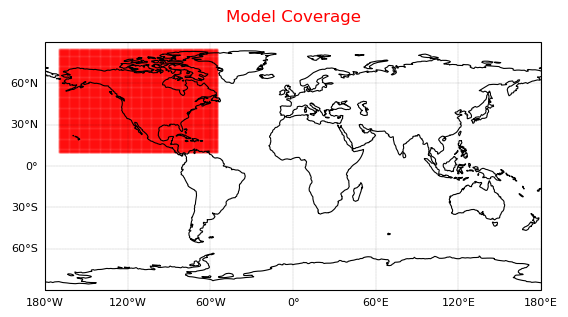

In [8]:
# --------------------------------- Code starts

# Display the model coordinates .
utils.plot_model_area(x_variable, x_values, y_variable, y_values)


display(Markdown(f"\n\n## {x_variable}:\n"))
print(x_values)

display(Markdown(f"\n\n## {y_variable}:\n"))
print(y_values)

if z_values is not None and ndim['model'] > 2:
    display(Markdown(f"\n\n## {z_variable}:\n"))
    print(z_values)
    
utils.message("...done!")

<hr />
<img src="assets/emc_hslice.png" style="vertical-align:top; float:right;" /> 

## [O] Horizontal Slice
### Plot one or more horizontal (depth) slice 


To customize the plots, update the following variables:
* data_var - Model variable to create the slice for (will use the **default_data_var** value if not defined)
* x_range - Plot range (min, max) along the X coordinate (**[]** for all)
* y_range - Plot range (min, max) along the Y coordinate (**[]** for all)
* z_range - For 3D models only (has no effect on the 2D model slices, **[]** for all)
* z_step - For 3D models only, is used for decimating (resampling) the depth values (set **z_step = 1** for all depths)
* colormap - The [matplotlib colormap](https://matplotlib.org/stable/tutorials/colors/colormaps.html) to use for the maps
* save_tag - A string to include in the file names to uniquely identify this run
* save_plots - Save each plots under the **output_dir** (True/False)
* save_data - Save each map's data under the **output_dir** (True/False)



<span style='color:blue; font-weight:bold'>'data_var' not defined and set to the 'default_data_var' value of 'dvs'</span>



longitude variable range selected -170.00 to -55.00 from -170.00 to -55.00
latitude variable range selected 10.00 to 85.00 from 10.00 to 85.00
depth variable range selected 70.00 to 671.00 from 70.00 to 671.00




<span style='color:blue; font-weight:300'>Model data variables: ['dvs']</span>





<span style='color:blue; font-weight:bold'>Plotting: dvs</span>



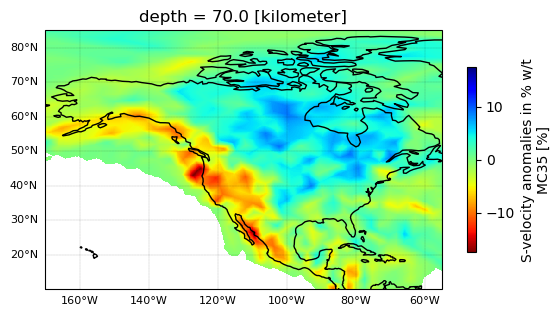

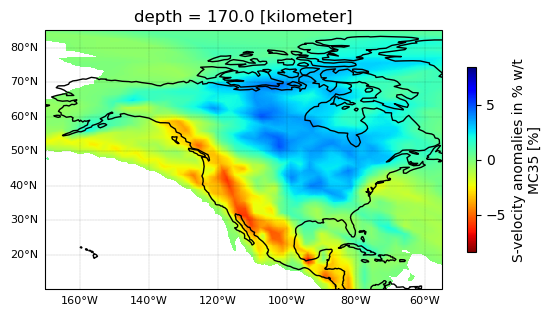

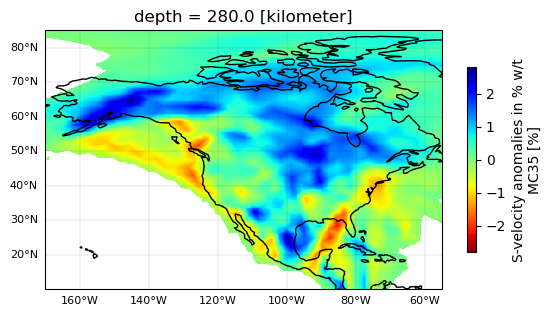

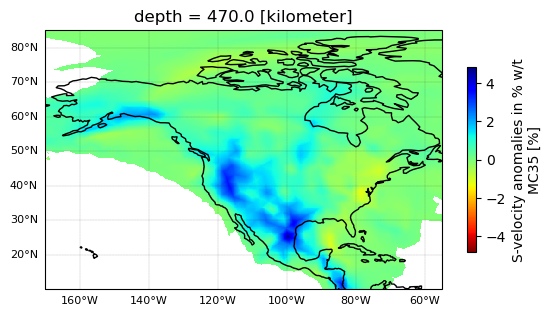

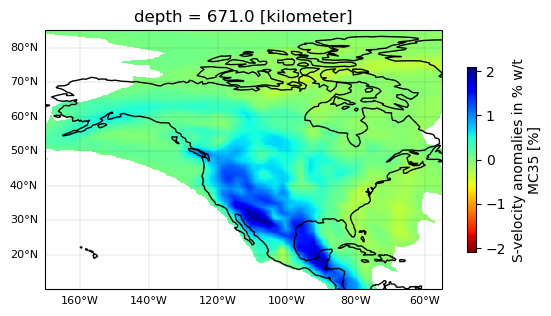



<span style='color:blue; font-weight:bold'>...done!</span>



In [9]:
# Run parameters
# Assigne the desired variable.
data_var = ''

# Range of variables [minimum, maximum] to use. To output all, set to empty ([]). 
# Z values are used only for 3D models. Use Z_STEP to decimate (resample) the depth values (set Z_STEP = 1 for all depths).
x_range = [] 
y_range = [] 
z_range = []
z_step = 5

# matplotlib colormap to use. For available colormaps see:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormap ='jet_r'

# Save plot and data flags. SAVE_TAG will be added to the file names.
save_tag = "test"
save_plots = True
save_data = True

# --------------------------------- Code starts

if not data_var:
    data_var = default_data_var
    utils.message(f"'data_var' not defined and set to the 'default_data_var' value of '{data_var}'")
    
if data_var not in data_variables:
    utils.message(f"selected 'data_var' '{data_var}' is not a valid model variable.<br />"
                          f"'data_var' must be one of {data_variables}", color='red')  
else:
    
    x_data, x_min, x_max, y_data, y_min, y_max, z_data, z_min, z_max = utils.get_ranges(x_variable, x_range, x_values, 
                                                                                        y_variable, y_range, y_values, 
                                                                                        z_variable, z_range, z_values, 
                                                                                        ndim['model'])

    dsv = utils.get_dsv(ds, data_var)
    if ndim[data_var] == 3:
        z = utils.get_range_values(z_values, (z_min, z_max))
    else:
        z = [1]

    dsv = ds[data_var]

    if 'display_name' in dsv.variable.attrs:
        title = dsv.variable.attrs['display_name']
    elif 'long_name' in dsv.variable.attrs:
        title = dsv.variable.attrs['long_name']
    else:
        title = data_var

    utils.message(f"Model data variables: {data_variables}", weight=300)
    utils.message(f"Plotting: {data_var}")
    for depth in z[::z_step]:
        if ndim[data_var] == 3:
            zslice = dsv.where((dsv[x_variable] >= x_min) & (dsv[x_variable] <= x_max) &
                                    (dsv[y_variable] >= y_min) & (dsv[y_variable] <= y_max) &
                                    (dsv[z_variable] == depth), drop=True)
        else:
            zslice = dsv.where((dsv[x_variable] >= x_min) & (dsv[x_variable] <= x_max) &
                                (dsv[y_variable] >= y_min) & (dsv[y_variable] <= y_max), drop=True)
        plt = utils.plot_hslice(zslice, x_variable, x_min, x_max, y_variable, y_min, y_max, title, colormap)

        if ndim[data_var] == 3:
            utils.save_files(save_data, save_plots, zslice, plt, f"Z{depth:0.1f}km", save_tag, data_var, delimiter, base_file_name, default_extensions, output_path)
            plt.show()
        else:
            utils.save_files(save_data, save_plots, zslice, plt, f"Z", save_tag, data_var, delimiter, base_file_name, default_extensions, output_path)
            plt.show()

utils.message("...done!")

<hr />
<img src="assets/emc_xsection_x.png" style="vertical-align:top; float:right;" /> 

## [O] Vertical Slices Along the X-axis
### For a 3D data variable, plot vertical slices (cross sections) along the X-axis

To customize the plots, update the following variables:
* data_var - Model variable to create the slice for (will use the **default_data_var** value if not defined)
* x_range - Plot range (min, max) along the X coordinate
* x_step - For 3D models only, is used for decimating (resampling) the X values (set **x_step = 1** for all Xs)
* y_range - Plot range (min, max) along the Y coordinate
* z_range - For 3D models only (has no effect on the 2D model slices)
* vertical_exaggeration - The vertical exaggeration of the cross-section
* colormap - The [matplotlib colormap](https://matplotlib.org/stable/tutorials/colors/colormaps.html) to use for the maps
* save_tag - A string to include in the file names to uniquely identify this run
* save_plots - Save each plots under the **output_dir** (True/False)
* save_data - Save each map's data under the **output_dir** (True/False)




<span style='color:blue; font-weight:bold'>'data_var' not defined and set to the 'default_data_var' value of 'dvs'</span>



longitude variable range selected -170.00 to -55.00 from -170.00 to -55.00
latitude variable range selected 10.00 to 85.00 from 10.00 to 85.00
depth variable range selected 70.00 to 671.00 from 70.00 to 671.00


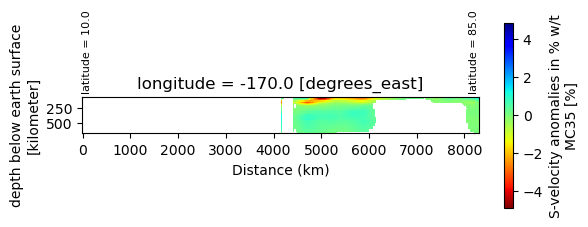

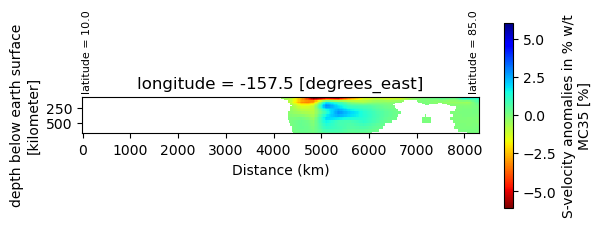

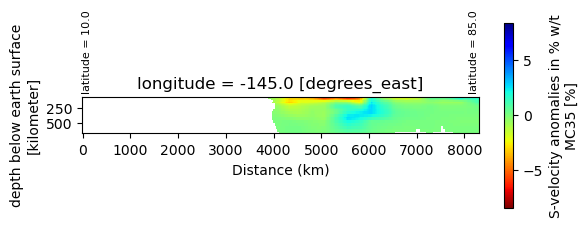

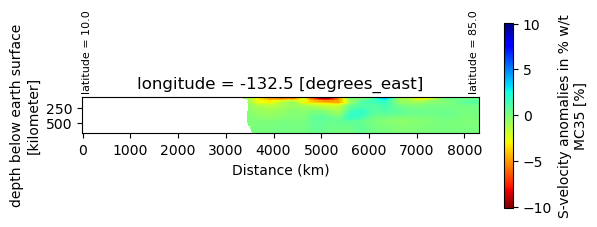

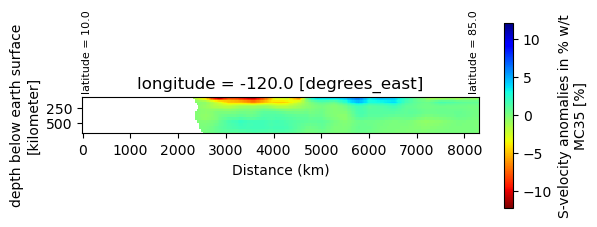

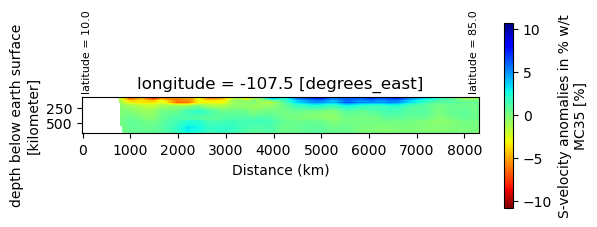

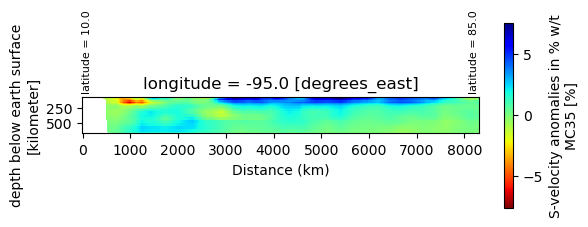

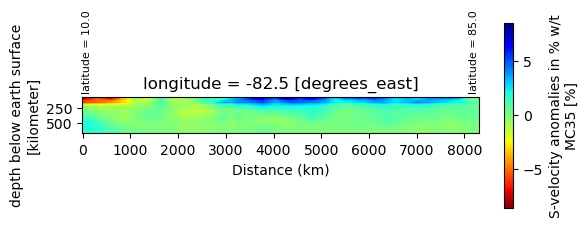

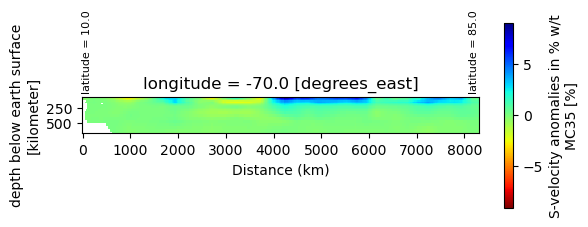

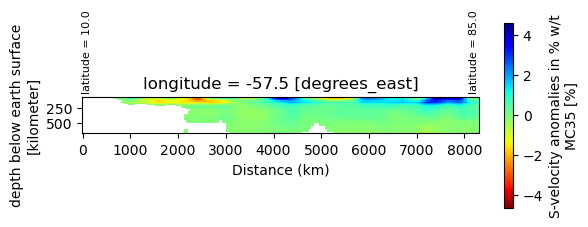



<span style='color:blue; font-weight:bold'>...done!</span>



In [10]:
# Assigne the desired variable.
data_var = ''

# Range of variables [minimum, maximum] to use. To output all, set to empty ([]). 
# Use the x_step to decimate (resample) the x values (set x_step = 1 for all x values).
xrange = []
x_step = 50

y_range = [] 
z_range = []

# The vertical exaggeration factor for the cross-section.
vertical_exaggeration = 10

# matplotlib colormap to use. For available colormaps see:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormap ='jet_r'

# Save plot and data flags. SAVE_TAG will be added to the file names.
save_tag = "test"
save_plots = True
save_data = True

# --------------------------------- Code starts
if not data_var:
    data_var = default_data_var
    utils.message(f"'data_var' not defined and set to the 'default_data_var' value of '{data_var}'")
    
if data_var not in data_variables:
    utils.message(f"selected 'data_var' '{data_var}' is not a valid model variable.<br />"
                          f"'data_var' must be one of {data_variables}", color='red')  
elif ndim[data_var] != 3:
    utils.message(f"{data_var} is a {ndim[data_var]}D variable. Plot of the vertical slices (cross sections) is only for 3D variables", color='red')
else:    
    x_data, x_min, x_max, y_data, y_min, y_max, z_data, z_min, z_max = utils.get_ranges(x_variable, x_range, x_values, 
                                                                                        y_variable, y_range, y_values, 
                                                                                        z_variable, z_range, z_values, 
                                                                                        ndim[data_var])

    x = utils.get_range_values(x_values, (x_min, x_max))
    dsv = utils.get_dsv(ds, data_var)
    for _x in x[::x_step]:
        xsection = dsv.where((dsv[y_variable] >= y_min) & (dsv[y_variable] <= y_max) &
                                (dsv[z_variable] >= z_min) & (dsv[z_variable] <= z_max) &
                                (dsv[x_variable] == _x), drop=True)
        
        lon = xsection.longitude.values[0]
        lat_values = xsection.latitude.values
        dist = list()
        for lat_index, lat in enumerate(lat_values):
            if lat_index == 0:
                dist.append(0)
                lat0 = lat
            else:
                _dist = utils.great_circle_distance(lat0, lon, lat, lon)
                dist.append(_dist)
        

        xsection['latitude'] = ('latitude', np.array(dist))
        im = xsection.plot(x="latitude", y="depth", cmap=colormap, cbar_kwargs={'shrink': 0.5})
        xy_ratio = utils.calc_xy_ratio((y_max, y_min), (z_max, z_min), factor=vertical_exaggeration)
        ax = plt.gca()
        ax.invert_yaxis()
        plt.xlabel('Distance (km)')
        ax.set_aspect(xy_ratio)
                
        ax.text(0, 1.1, f"latitude = {y_min:0.1f}",
        horizontalalignment='left',
        verticalalignment='bottom',
        fontsize=8,
        rotation=90,
        transform=ax.transAxes)

        ax.text(1, 1.1, f"latitude = {y_max:0.1f}",
        horizontalalignment='right',
        verticalalignment='bottom',
        fontsize=8,
        rotation=90,
        transform=ax.transAxes)
        utils.save_files(save_data, save_plots, xsection, plt, f"X{_x:0.1f}km", save_tag, data_var, delimiter, 
                         base_file_name, default_extensions, output_path)
        plt.show()

utils.message("...done!")

<hr />
<img src="assets/emc_xsection_y.png" style="vertical-align:top; float:right;" /> 

## [O] Vertical Slices Along the Y-axis
### For a 3D model, plot vertical slices (cross sections) along the Y-axis


To customize the plots, update the following variables:
* data_var - Model variable to create the slice for (will use the **default_data_var** value if not defined)
* x_range - Plot range (min, max) along the X coordinate
* y_range - Plot range (min, max) along the Y coordinate
* y_step - For 3D models only, is used for decimating (resampling) the Y values (set **y_step = 1** for all Ys)
* z_range - For 3D models only (has no effect on the 2D model slices)
* vertical_exaggeration - The vertical exaggeration of the cross-section
* colormap - The [matplotlib colormap](https://matplotlib.org/stable/tutorials/colors/colormaps.html) to use for the maps
* save_tag - A string to include in the file names to uniquely identify this run
* save_plots - Save each plots under the **output_dir** (True/False)
* save_data - Save each map's data under the **output_dir** (True/False)



<span style='color:blue; font-weight:bold'>'data_var' not defined and set to the 'default_data_var' value of 'dvs'</span>



longitude variable range selected -170.00 to -55.00 from -170.00 to -55.00
latitude variable range selected 10.00 to 85.00 from 10.00 to 85.00
depth variable range selected 70.00 to 671.00 from 70.00 to 671.00


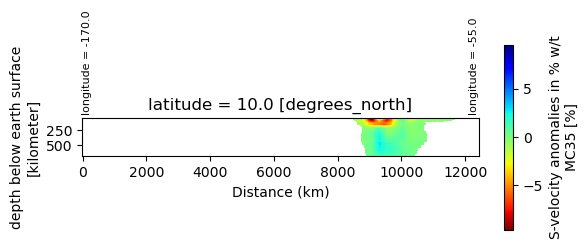

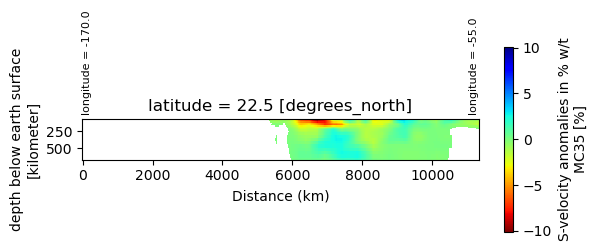

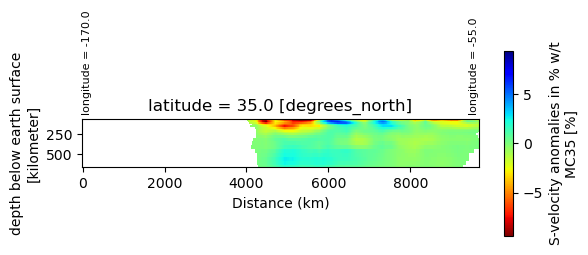

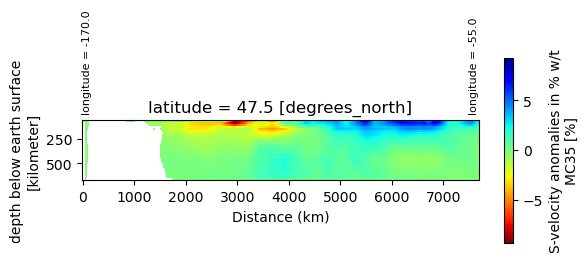

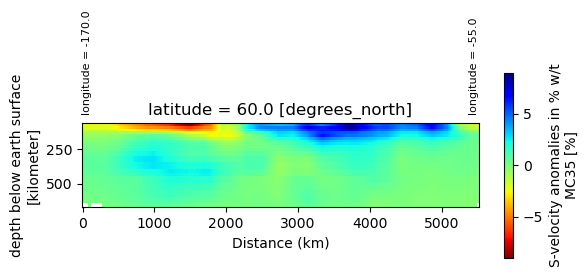

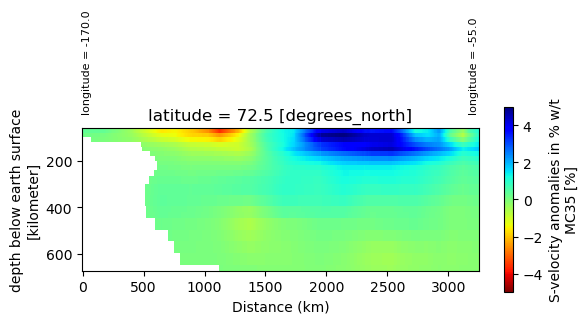

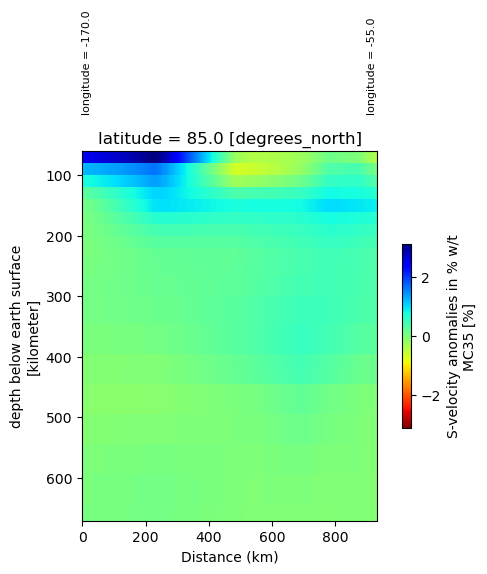



<span style='color:blue; font-weight:bold'>...done!</span>



In [11]:
# Assigne the desired variable.
data_var = ''

# Range of variables [minimum, maximum] to use. To output all, set to empty ([]). 
xrange = [] 

# Use the y_step to decimate (resample) the y values (set y_step = 1 for all y values).
y_range = []
y_step = 50

z_range = []

# The vertical exaggeration factor for the cross-section.
vertical_exaggeration = 10

# matplotlib colormap to use. For available colormaps see:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormap ='jet_r'

# Save plot and data flags. SAVE_TAG will be added to the file names.
save_tag = "test"
save_plots = True
save_data = True

# --------------------------------- Code starts
if not data_var:
    data_var = default_data_var
    utils.message(f"'data_var' not defined and set to the 'default_data_var' value of '{data_var}'")
    
if data_var not in data_variables:
    utils.message(f"selected 'data_var' '{data_var}' is not a valid model variable.<br />"
                          f"'data_var' must be one of {data_variables}", color='red')  
elif ndim[data_var] != 3:
    utils.message(f"{data_var} is a {ndim[data_var]}D variable. Plot of the vertical slices (cross sections) is only for 3D variables", color='red')
else:    
    x_data, x_min, x_max, y_data, y_min, y_max, z_data, z_min, z_max = utils.get_ranges(x_variable, x_range, x_values, 
                                                                                        y_variable, y_range, y_values, 
                                                                                        z_variable, z_range, z_values, 
                                                                                        ndim[data_var])

    y = utils.get_range_values(y_values, (y_min, y_max))

    dsv = utils.get_dsv(ds, data_var)
    for _y in y[::y_step]:
        xsection = dsv.where((dsv[x_variable] >= x_min) & (dsv[x_variable] <= x_max) &
                                (dsv[z_variable] >= z_min) & (dsv[z_variable] <= z_max) &
                                (dsv[y_variable] == _y), drop=True)
        
        lat = xsection.latitude.values[0]
        lon_values = xsection.longitude.values
        dist = list()
        for lon_index, lon in enumerate(lon_values):
            if lon_index == 0:
                dist.append(0)
                lon0 = lon
            else:
                _dist = utils.great_circle_distance(lat, lon0, lat, lon)
                dist.append(_dist)
        

        xsection['longitude'] = ('longitude', np.array(dist))
        im = xsection.plot(x="longitude", y="depth", cmap=colormap, cbar_kwargs={'shrink': 0.5})
        xy_ratio = utils.calc_xy_ratio((x_max, x_min), (z_max, z_min), factor=vertical_exaggeration)
        ax = plt.gca()
        ax.invert_yaxis()
        plt.xlabel('Distance (km)')
        ax.set_aspect(xy_ratio)
                
        ax.text(0, 1.1, f"longitude = {x_min:0.1f}",
        horizontalalignment='left',
        verticalalignment='bottom',
        fontsize=8,
        rotation=90,
        transform=ax.transAxes)

        ax.text(1, 1.1, f"longitude = {x_max:0.1f}",
        horizontalalignment='right',
        verticalalignment='bottom',
        fontsize=8,
        rotation=90,
        transform=ax.transAxes)
        plt.show()
        
utils.message("...done!")

<hr />
<img src="assets/emc_profile_x.png" style="vertical-align:top; float:right;" /> 

## [O] Vertical Profiles Along the X-axis
### Plot one or more vertical profiles for a 3D model (change of data values with depth) along the X-axis 

To customize the plots, update the following variables::
* data_var - Model variable to create the profile for (will use the **default_data_var** value if not defined)
* x_range - Plot range (min, max) along the X coordinate
* x_step - For 3D models only, is used for decimating (resampling) the X values (set **x_step = 1** for all Xs)
* y_range - Plot range (min, max) along the Y coordinate
* y_step - For 3D models only, is used for decimating (resampling) the Y values (set **y_step = 1** for all Ys)
* z_range - For 3D models only (has no effect on the 2D model slices)
* save_tag - A string to include in the file names to uniquely identify this run
* save_plots - Save each plots under the **output_dir** (True/False)
* save_data - Save each map's data under the **output_dir** (True/False)




<span style='color:blue; font-weight:bold'>'data_var' not defined and set to the 'default_data_var' value of 'dvs'</span>



longitude variable range selected -170.00 to -55.00 from -170.00 to -55.00
latitude variable range selected 10.00 to 85.00 from 10.00 to 85.00
depth variable range selected 70.00 to 671.00 from 70.00 to 671.00


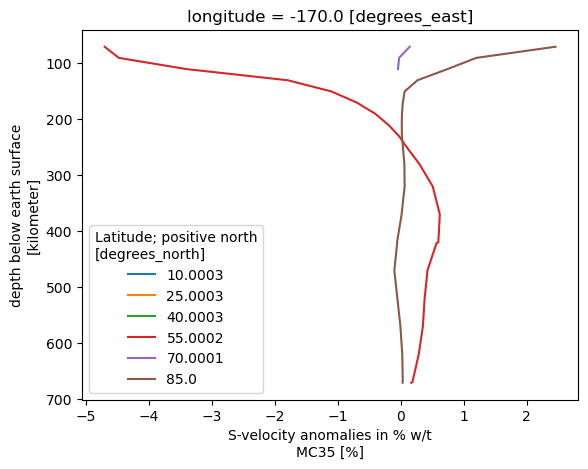

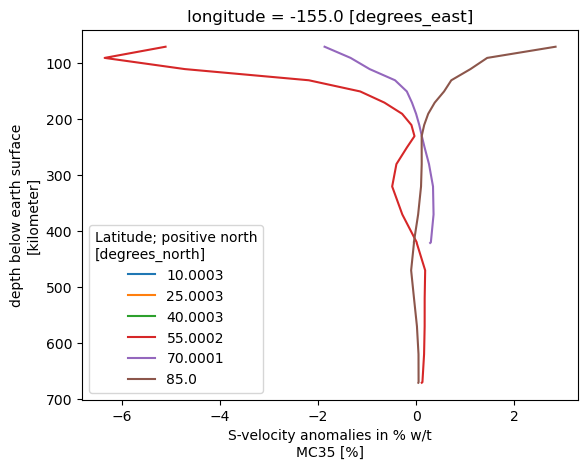

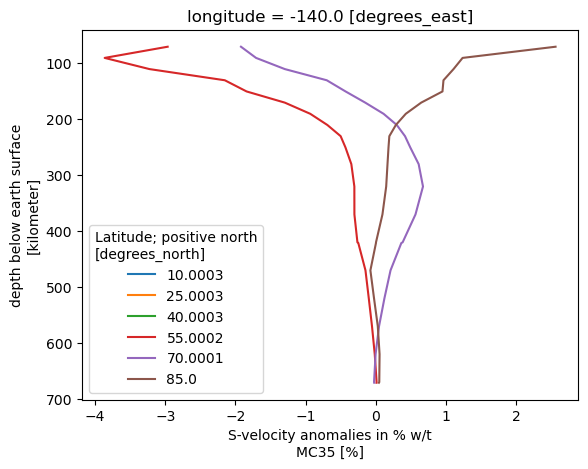

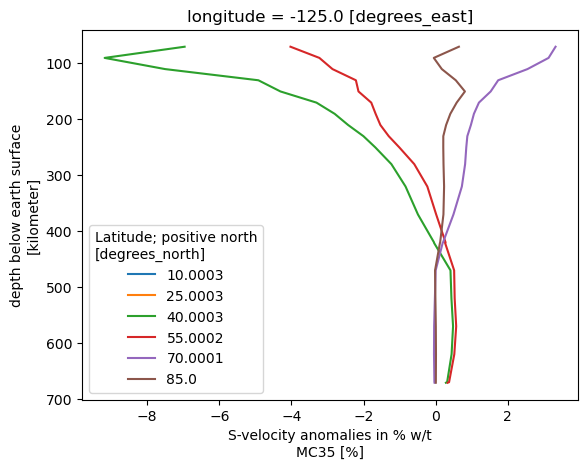

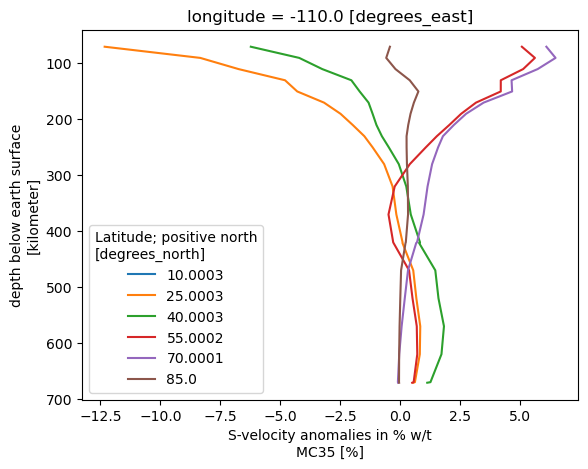

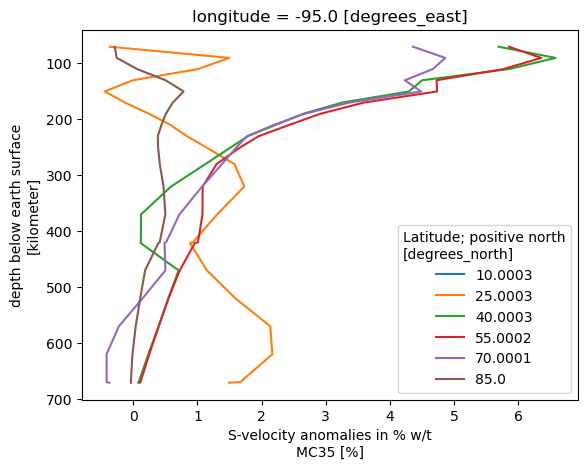

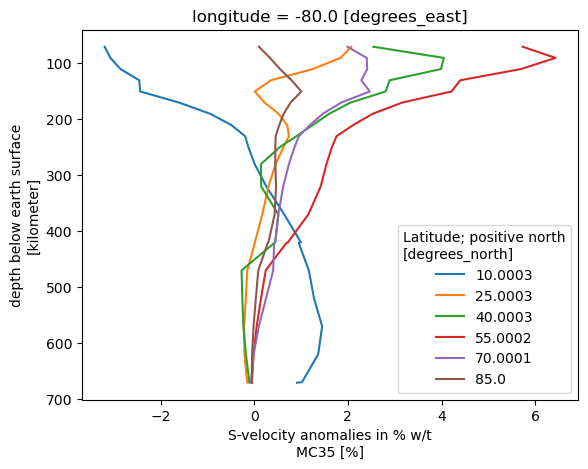

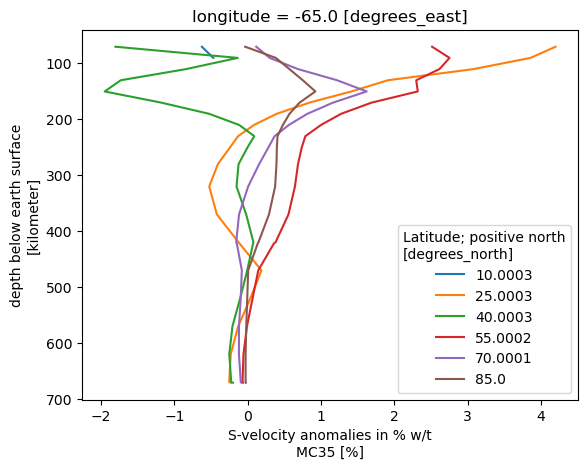



<span style='color:blue; font-weight:bold'>...done!</span>



In [12]:
# Assigne the desired variable.
data_var = ''

# Range of variables [minimum, maximum] to use. To output all, set to empty ([]). 
# Use the Y_STEP to decimate (resample) the Y values (set Y_STEP = 1 for all Y values).
x_range = []
x_step = 60

y_range = []
y_step = 60

z_range = []

# Save plot and data flags. SAVE_TAG will be added to the file names.
save_plots = True
save_data = True
save_tag = "test"

# --------------------------------- Code starts
if not data_var:
    data_var = default_data_var
    utils.message(f"'data_var' not defined and set to the 'default_data_var' value of '{data_var}'")
    
if data_var not in data_variables:
    utils.message(f"selected 'data_var' '{data_var}' is not a valid model variable.<br />"
                          f"'data_var' must be one of {data_variables}", color='red')  
elif ndim[data_var] != 3:
    utils.message(f"{data_var} is a {ndim[data_var]}D variable. Plot of the depth profiles is only for 3D variables", color='red')
else:  
    x_data, x_min, x_max, y_data, y_min, y_max, z_data, z_min, z_max = utils.get_ranges(x_variable, x_range, x_values, 
                                                                                        y_variable, y_range, y_values, 
                                                                                        z_variable, z_range, z_values, 
                                                                                        ndim[data_var])

    x = utils.get_range_values(x_values, (x_min, x_max))
    y = utils.get_range_values(y_values, (y_min, y_max))

    dsv = utils.get_dsv(ds, data_var)
    for _x in x[::x_step]:
        profile = dsv.sel(longitude =_x, latitude= y[::y_step])

        profile.plot.line(y='depth', hue='latitude')
        plt.gca().invert_yaxis()

        utils.save_files(save_data, save_plots, profile, plt, f"XP{_x:0.1f}deg", 
                         save_tag, data_var, delimiter, base_file_name, default_extensions, 
                         output_path)
        plt.show()

utils.message("...done!")

<hr />
<img src="assets/emc_profile_x.png" style="vertical-align:top; float:right;" /> 

## [O] Vertical Profiles Along the Y-axis
### Plot one or more vertical profiles for a 3D model (change of parameter with depth) along the Y-axis 

To customize the plots, update the following variables:
* data_var - Model variable to create the profile for (will use the **default_data_var** value if not defined)
* x_range - Plot range (min, max) along the X coordinate
* x_step - For 3D models only, is used for decimating (resampling) the X values (set **x_step = 1** for all Xs)
* y_range - Plot range (min, max) along the Y coordinate
* y_step - For 3D models only, is used for decimating (resampling) the Y values (set **y_step = 1** for all Ys)
* z_range - For 3D models only (has no effect on the 2D model slices)
* save_tag - A string to include in the file names to uniquely identify this run
* save_plots - Save each plots under the **output_dir** (True/False)
* save_data - Save each map's data under the **output_dir** (True/False)



<span style='color:blue; font-weight:bold'>'data_var' not defined and set to the 'default_data_var' value of 'dvs'</span>



longitude variable range selected -170.00 to -55.00 from -170.00 to -55.00
latitude variable range selected 10.00 to 85.00 from 10.00 to 85.00
depth variable range selected 70.00 to 671.00 from 70.00 to 671.00


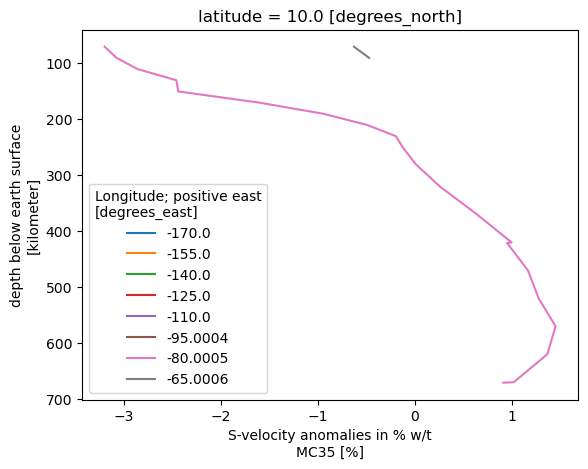

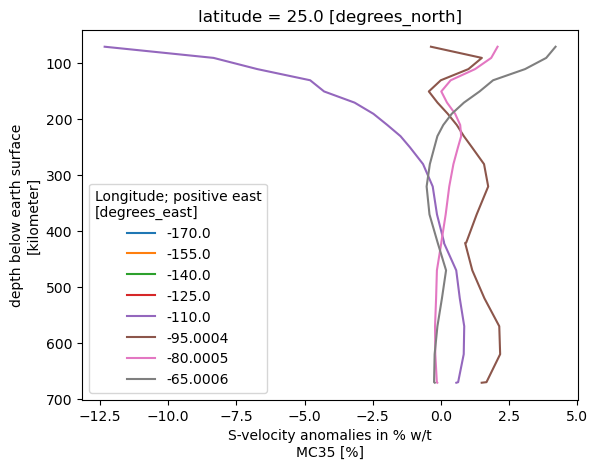

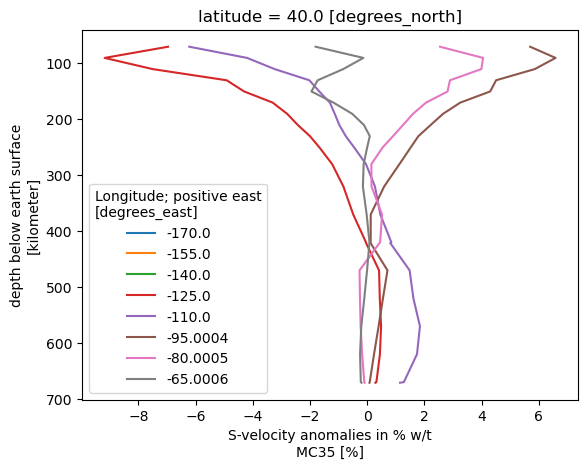

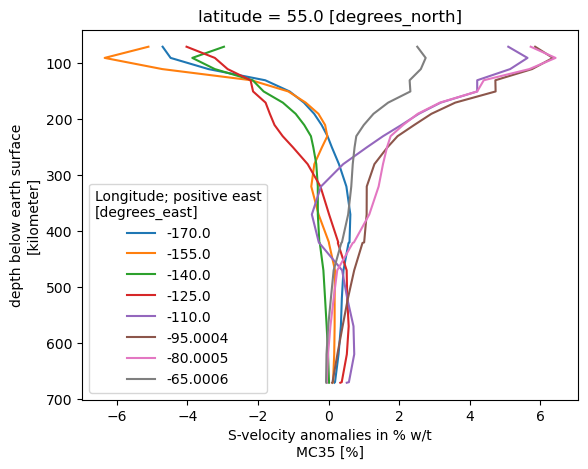

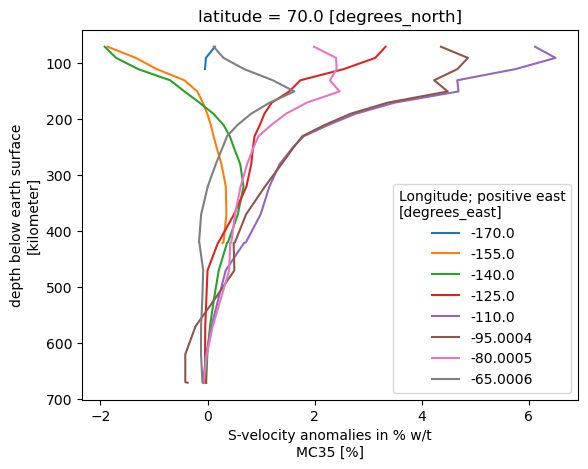

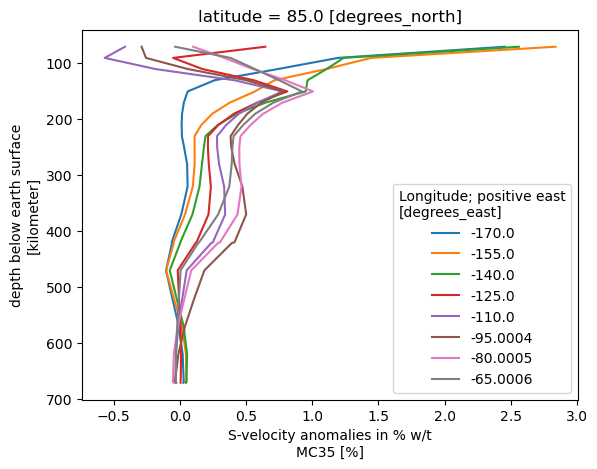



<span style='color:blue; font-weight:bold'>...done!</span>



In [13]:
# Assigne the desired variable.
data_var = ''

# Range of variables [minimum, maximum] to use. To output all, set to empty ([]). 
# Use the Y_STEP to decimate (resample) the Y values (set Y_STEP = 1 for all Y values).
x_range = []
x_step = 60

y_range = []
y_step = 60

z_range = []

# Save plot and data flags. SAVE_TAG will be added to the file names.
save_plots = True
save_data = True
save_tag = "test"

# --------------------------------- Code starts
if not data_var:
    data_var = default_data_var
    utils.message(f"'data_var' not defined and set to the 'default_data_var' value of '{data_var}'")
    
if data_var not in data_variables:
    utils.message(f"selected 'data_var' '{data_var}' is not a valid model variable.<br />"
                          f"'data_var' must be one of {data_variables}", color='red')  
elif ndim[data_var] != 3:
    utils.message(f"{data_var} is a {ndim[data_var]}D variable. Plot of the depth profiles is only for 3D variables", color='red')
else:  
    x_data, x_min, x_max, y_data, y_min, y_max, z_data, z_min, z_max = utils.get_ranges(x_variable, x_range, x_values, 
                                                                                        y_variable, y_range, y_values, 
                                                                                        z_variable, z_range, z_values, 
                                                                                        ndim[data_var])

    x = utils.get_range_values(x_values, (x_min, x_max))
    y = utils.get_range_values(y_values, (y_min, y_max))

    dsv = utils.get_dsv(ds, data_var)
    for _y in y[::y_step]:
        profile = dsv.sel(longitude =x[::x_step], latitude= _y)

        profile.plot.line(y='depth', hue='longitude')
        plt.gca().invert_yaxis()

        utils.save_files(save_data, save_plots, profile, plt, f"YP{_x:0.1f}deg", 
                         save_tag, data_var, delimiter, base_file_name, default_extensions, 
                         output_path)
        plt.show()
        
utils.message("...done!")

<hr />

## Output in GeoCSV Format
### Output the model or a subset of the model via in GeoCSV format.

To customize the outputs, update the following variables:
* output_mode = must be either 'single' or 'depth'
   * depth: One output file per depth.
   * single: a single output file that contains all depths.
* variable_list - List of the model variables to output (**[]** for all). 
* x_range - X-coordinate range (min, max) to extract model data for (**[]** for all) 
* x_staep - Decimation (resampling) in the X direction (set **x_step = 1** for all X values)
* y_range - Y-coordinate range (min, max) to extract model data for (**[]** for all)
* y_step - Decimation (resampling) in the Y direction (set **y_step = 1** for all Y 
* z_range - Z-coordinate range (min, max) to extract model data for (**None** for 2D models and **[]** for all Z values)
* save_tag - A string to include in the file names to uniquely identify this run

In [ ]:
# Output the model in GeoCSV
data_vars = []

# depth: One output file per depth.
# single: a single output file that contains all depths.
output_mode = 'single'

# Range of variables [minimum, maximum] to use. To output all, set to empty ([]). 
# Use the Y_STEP to decimate (resample) the Y values (set Y_STEP = 1 for all Y values).
x_range = []
x_step = 1
y_range = []
y_step = 1
z_range = []

save_tage = "test"

# ---------------------------------

run_args['variable_list'] = data_vars

run_args['x_range'] = x_range
run_args['x_step'] = x_step
run_args['y_range'] = y_range
run_args['y_step'] = y_step
run_args['z_range'] = z_range

if output_mode not in list(valid_modes):
    raise UserWarning(f"Invalid 'output_mode' of '{output_mode}' set output_mode to one of {valid_modes} types."
                       "Stop! Please update the 'output_mode' variable")
if len(x_range) not in (0, 2):
    raise UserWarning(f"Invalid 'x_range' of '{x_range}' must be either and empty range for all ([]) for sould have min and max values"
                       "Stop! Please update the 'x_range' variable")

if len(y_range) not in (0, 2):
    raise UserWarning(f"Invalid 'y_range' of '{y_range}' must be either and empty range for all ([]) for sould have min and max values"
                       "Stop! Please update the 'y_range' variable")

if len(z_range) not in (0, 2):
    raise UserWarning(f"Invalid 'z_range' of '{z_range}' must be either and empty range for all ([]) for sould have min and max values"
                       "Stop! Please update the 'z_range' variable")

utils.make_model_geocsv(run_args, output_mode)

utils.message("...done!")

longitude variable range selected -170.00 to -55.00 from -170.00 to -55.00
latitude variable range selected 10.00 to 85.00 from 10.00 to 85.00
depth variable range selected 70.00 to 671.00 from 70.00 to 671.00
[INFO] Output file: /Users/manoch/Projects/Notebook/EMC/output/NA07_percent/NA07_percent.csv
[INFO] Processing variable: dvs
[INFO] 21 depths index:0  301 latitudes index:1  461 longitudes index:2  


/Users/manoch/Projects/Notebook/EMC/notebooks/emc_utils.py:598: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(emcin[var][index[0]][index[1]][index[2]]):


[INFO] Depth range: 70.00 to 671.00
70.0, 90.0, 110.00, 130.00, 150.00, 170.00, 190.00, 210.00, 